In [134]:
from pandas import DataFrame, date_range, read_table, to_datetime
from datetime import datetime, timedelta, date
from collections import defaultdict
from itertools import product
import numpy as np
from matplotlib import pyplot as plt

In [122]:
path = '/home/diego/Documents/Salidas/'
file_names = {'ClinicaSantaRosa-HospitalUniversitario':'datos_jardin.csv',
             'Marengo_1':'datos_tibaitata.csv',
             'EBTRF_Villavicencio':'datos_icavill.csv',
             'MuseoVillaDeLeyva':'datos_villa.csv'}
obs = {'ClinicaSantaRosa-HospitalUniversitario':None,
             'Marengo_1':None,
             'EBTRF_Villavicencio':None,
             'MuseoVillaDeLeyva':None}
dates = date_range(start='2019-11-01', end='2020-01-15')

#Open observation files
for file in file_names.keys():
    obs[file] = read_table('{}{}'.format(path, file_names[file]), sep=',')
    obs[file] = obs[file].drop_duplicates(subset="Fecha")
    obs[file].index = obs[file]['Fecha']
    obs[file].index = to_datetime(obs[file].index)
    
#Open forecast files
forecast = {0:None, 1:None, 2:None}
for file in (0, 1, 2):
    forecast[file] = read_table('{}Prec_{}.csv'.format(path, file), sep=',')
    forecast[file]['Date'] = to_datetime(forecast[file]['Date'])
    forecast[file].index = forecast[file]['Date']

In [123]:
# Hourly forecast to daily forecast
forecast_daily = {0:None, 1:None, 2:None}

for forday, date in product((0, 1, 2), dates):
    if date == dates[0]:
        df = DataFrame(columns=forecast[0].columns)
    day = datetime.strftime(date, '%Y/%m/%d')
    nextday = datetime.strftime(date + timedelta(days=1), '%Y/%m/%d')
    row = forecast[forday].loc['{} 07:00:00'.format(day):
                               '{} 07:00:00'.format(nextday)].sum()
    row.name = day
    df = df.append(row)
    if date == dates[-1]:
        df.index = to_datetime(df.index)
        forecast_daily[forday] = df

## RMSE
$$RMSE = \left[ \frac{1}{n} \sum_{i=1}^{i=n}{ (Y_i - \hat{Y_i})^2 }\right]$$

## ME

$$ ME = \frac{1}{n} \sum_{i=1}^{i=n} Y_i - \hat{Y_i}$$

In [124]:
def rmse(obs, forescast):
    '''Root meen square Error
    observation and forecast are same length iterable objects, 
    it returns RMSE as float'''
    SUM = [(i - j)**2 for i, j in zip(obs, forecast)]
    n = len(obs)
    return (1/n * np.nansum(SUM))**0.5

def bias(obs, forecast):
    '''Return BIAS as Mean Error'''
    SUM = [i - j for i, j in zip(obs, forecast)]
    n = len(obs)
    return (1/n * np.nansum(SUM))

def contingency_table(obs, forecast, geqt = 1):
    """Returns the four tipical values for a 
    contengency table and the n value"""
    a = []; b = []; c = []; d = []
    n = 0
    for OBS, FOR in zip(obs, forecast):
        if not (np.isnan(OBS) or np.isnan(FOR)):
            n += 1
            if OBS >= geqt and FOR >= geqt:
                a.append(1)
            elif not(OBS >= geqt) and FOR >= geqt:
                b.append(1)
            elif OBS >= geqt and not(FOR >= geqt):
                c.append(1)
            else:
                d.append(1)
    return {'a':sum(a), 'b':sum(b), 'c':sum(c),
           'd':sum(d), 'n':n}
    

In [160]:
"""Print forecast index for every day and point"""
for day in (0, 1, 2):
    print('============== Day {} =============='.format(day))
    for point in obs.keys():
        print('********{}********'.format(point))
        OBS = []; FOR = []
        for date in forecast_daily[day].index:
            try:
                OBS.append(obs[point].loc[date]['Valor'])
            except KeyError:
                OBS.append(np.nan)
            try:
                FOR.append(forecast_daily[day].loc[date][point])
            except KeyError:
                FOR.append(np.nan)
        contab = contingency_table(OBS, FOR, geqt=1)
        print('RMSE = {:.3f}'.format(rmse(OBS, FOR)))
        print('BIAS = {:.3f}'.format(bias(OBS, FOR)))
        print('PC(1mm) = {:.3f}'.format((contab['a'] + contab['d'])/contab['n']))
        contab = contingency_table(OBS, FOR, geqt=10)
        print('PC(10mm) = {:.3f}'.format((contab['a'] + contab['d'])/contab['n']))

============== Day 0 ==============
********ClinicaSantaRosa-HospitalUniversitario********
RMSE = 0.000
BIAS = -4.895
PC(1mm) = 0.500
PC(10mm) = 0.633
********Marengo_1********
RMSE = 0.567
BIAS = 0.026
PC(1mm) = 0.635
PC(10mm) = 0.986
********EBTRF_Villavicencio********
RMSE = 2.176
BIAS = 2.013
PC(1mm) = 0.693
PC(10mm) = 0.733
********MuseoVillaDeLeyva********
RMSE = 0.651
BIAS = -2.888
PC(1mm) = 0.627
PC(10mm) = 0.827
============== Day 1 ==============
********ClinicaSantaRosa-HospitalUniversitario********
RMSE = 0.000
BIAS = -6.750
PC(1mm) = 0.450
PC(10mm) = 0.617
********Marengo_1********
RMSE = 0.567
BIAS = -0.684
PC(1mm) = 0.527
PC(10mm) = 0.919
********EBTRF_Villavicencio********
RMSE = 2.176
BIAS = 0.724
PC(1mm) = 0.653
PC(10mm) = 0.667
********MuseoVillaDeLeyva********
RMSE = 0.651
BIAS = -2.980
PC(1mm) = 0.613
PC(10mm) = 0.827
============== Day 2 ==============
********ClinicaSantaRosa-HospitalUniversitario********
RMSE = 0.000
BIAS = -7.868
PC(1mm) = 0.467
PC(10mm) = 0.55

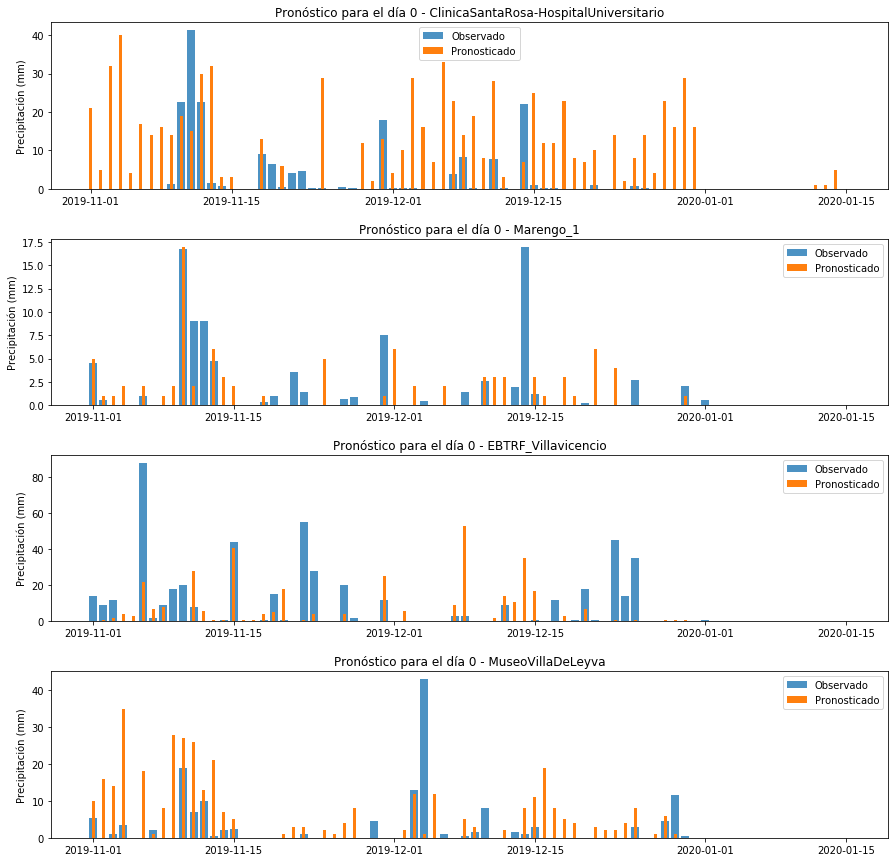

In [167]:
day = 0
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
plt.subplots_adjust(hspace=0.3)
for n, point in enumerate(obs.keys()):
    OBS = []; FOR = []
    for date in forecast_daily[day].index:
        try:
            OBS.append(obs[point].loc[date]['Valor'])
        except KeyError:
            OBS.append(np.nan)
        try:
            FOR.append(forecast_daily[day].loc[date][point])
        except KeyError:
            FOR.append(np.nan)
    x = forecast_daily[day].index
    ax[n].bar(x, OBS, alpha=0.8, label='Observado')
    ax[n].bar(x, FOR, width=0.3, label='Pronosticado')
    ax[n].set_ylabel('Precipitación (mm)')
    ax[n].legend()
    ax[n].set_title('Pronóstico para el día {} - {}'.format(day, point))
plt.show()

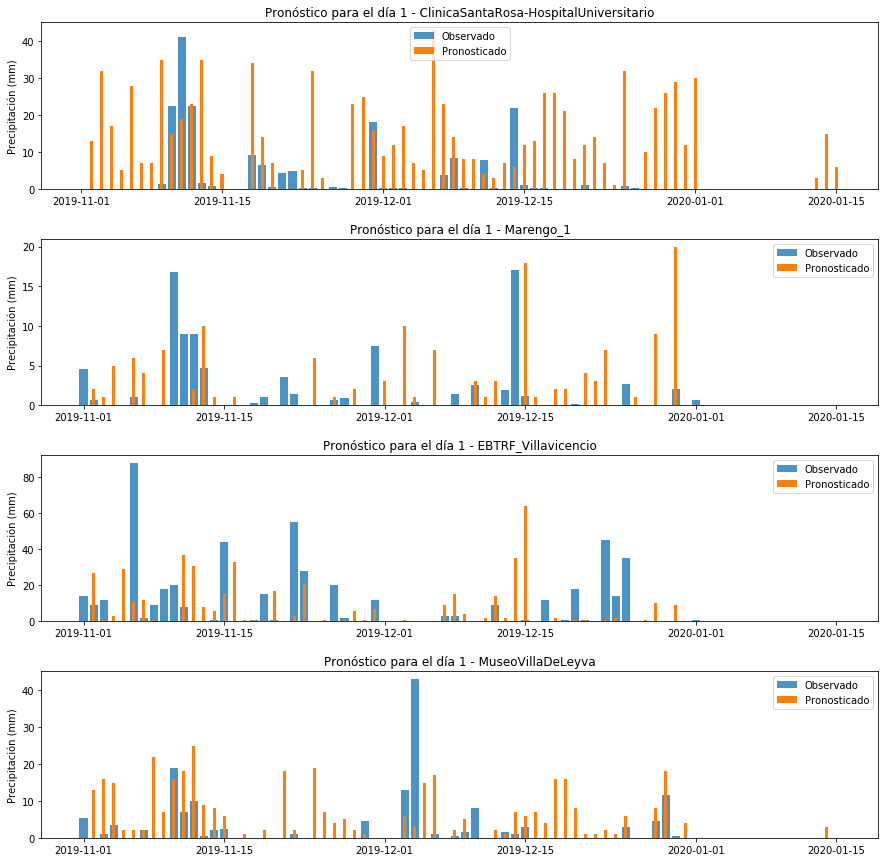

In [168]:
day = 1
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
plt.subplots_adjust(hspace=0.3)
for n, point in enumerate(obs.keys()):
    OBS = []; FOR = []
    for date in forecast_daily[day].index:
        try:
            OBS.append(obs[point].loc[date]['Valor'])
        except KeyError:
            OBS.append(np.nan)
        try:
            FOR.append(forecast_daily[day].loc[date][point])
        except KeyError:
            FOR.append(np.nan)
    x = forecast_daily[day].index
    ax[n].bar(x, OBS, alpha=0.8, label='Observado')
    ax[n].bar(x, FOR, width=0.3, label='Pronosticado')
    ax[n].set_ylabel('Precipitación (mm)')
    ax[n].legend()
    ax[n].set_title('Pronóstico para el día {} - {}'.format(day, point))
plt.show()

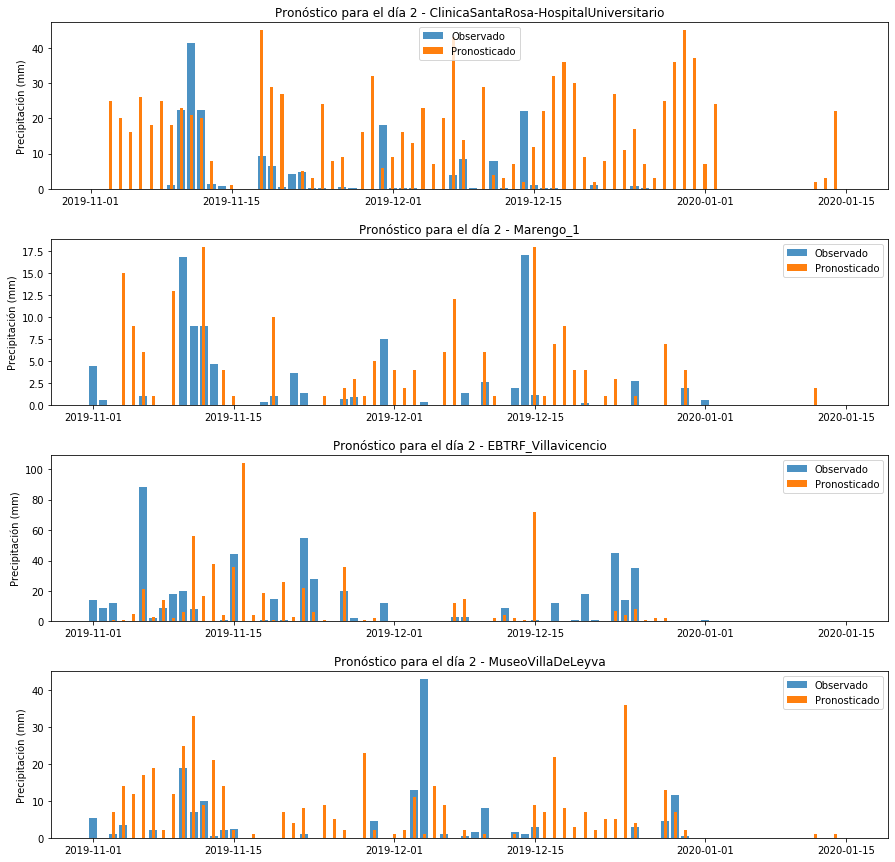

In [169]:
day = 2
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
plt.subplots_adjust(hspace=0.3)
for n, point in enumerate(obs.keys()):
    OBS = []; FOR = []
    for date in forecast_daily[day].index:
        try:
            OBS.append(obs[point].loc[date]['Valor'])
        except KeyError:
            OBS.append(np.nan)
        try:
            FOR.append(forecast_daily[day].loc[date][point])
        except KeyError:
            FOR.append(np.nan)
    x = forecast_daily[day].index
    ax[n].bar(x, OBS, alpha=0.8, label='Observado')
    ax[n].bar(x, FOR, width=0.3, label='Pronosticado')
    ax[n].set_ylabel('Precipitación (mm)')
    ax[n].legend()
    ax[n].set_title('Pronóstico para el día {} - {}'.format(day, point))
plt.show()